In [2]:
from matplotlib import pyplot as plt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import glob
from skimage.io import imread
import os
import pandas as pd
import cv2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Conv2D # swipe across the image by 1
from tensorflow.keras.layers import MaxPooling2D,MaxPool2D # swipe across by pool size
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback, EarlyStopping
from keras import backend as K


In [7]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [3]:
df = pd.DataFrame(columns=['Images','Classes'])


In [4]:
labels = os.listdir(r"/content/drive/MyDrive/GLAssignments/Plant Seedling Classification Data/train")
idx = 0
for label in labels:
    path = r"/content/drive/MyDrive/GLAssignments/Plant Seedling Classification Data/train/"+label
    files = os.listdir(path)
    generator = (path+'/'+file for file in files)
    for i in generator:
        df.loc[idx,['Images','Classes']] = [i,label]
        idx += 1

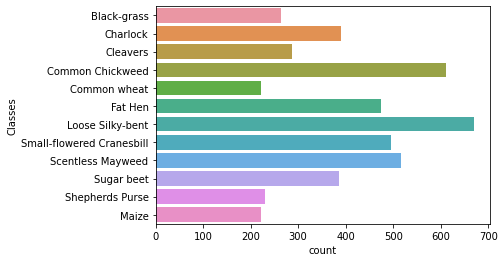

In [5]:
sns.countplot(y=df['Classes']);

In [6]:
df['Classes'].value_counts()

Loose Silky-bent             671
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Classes, dtype: int64

In [7]:
encoder = LabelEncoder()
labels = encoder.fit_transform(df['Classes'])
df['Encoded_Classes'] = labels

Label: Black-grass
Shape : (256, 256, 3)


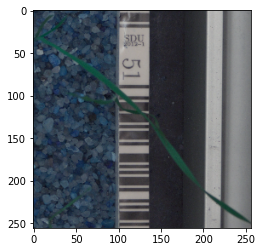

In [8]:
example_file =df.loc[2]['Images']
print("Label:",df.loc[2]['Classes'])
im = cv2.imread(example_file,1)
im_re = cv2.resize(im,(256,256))
print("Shape :",im_re.shape)
plt.imshow(im_re)
plt.show();

In [41]:
y = tensorflow.keras.utils.to_categorical(labels, num_classes=None, dtype='int')

In [30]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Supervised Learning Model creation

In [106]:
x_feat = []
y_feat = []
img_rows = 256
img_cols = 256
idx = 0
abs_path = r"/content/drive/MyDrive/GLAssignments/Plant Seedling Classification Data/train/"
train_folder = os.listdir(abs_path)
for i in tqdm(train_folder):
  path = abs_path+i
  files = os.listdir(path)
  generator = (path+'/'+file for file in files)
  for image in generator:
    img = cv2.imread(image,0) # 0 is to read image in grayscale mode
    img_resize = cv2.resize(img,(img_rows,img_cols))
    x_feat.append(img_resize.reshape(1,-1))
    y_feat.append(i)


100%|██████████| 12/12 [00:51<00:00,  4.33s/it]


### Saving lists for future use

In [4]:
def pickle_list(path,filename,list_name):
  with open(path+filename,'wb') as fp:
    pickle.dump(list_name,fp)

def unpickle_list(path,filename):
  with open(path+filename,'rb') as fp:
    list_name = pickle.load(fp)
  return list_name

In [5]:
path = r"/content/drive/MyDrive/GLAssignments/"

In [109]:
pickle_list(path,'encoded_labels.pkl',encoder.fit_transform(y_feat))

In [110]:
y_feature_encoded = unpickle_list(path,'encoded_labels.pkl')

### Normalization of image vector

In [112]:
X = np.array(x_feat,np.float32)/255
X = np.array([i[0] for i in X])

In [115]:
y = tensorflow.keras.utils.to_categorical(encoder.fit_transform(y_feat), num_classes=None, dtype='int')

In [118]:
X.shape

(4767, 65536)

In [119]:
y.shape

(4767, 12)

In [120]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [121]:
print(x_train.shape)
print(x_test.shape)

(3813, 65536)
(954, 65536)


In [160]:
steps = [('svc',SVC())]
pipe = Pipeline(steps)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'svc', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [161]:
params = dict()
params['svc__C'] = [1]
params['svc__kernel'] = ['rbf']
params['svc__gamma'] = ['auto']
params['svc__decision_function_shape'] = ['ovo']
svm = RandomizedSearchCV(pipe, params, n_iter=100, scoring='r2', n_jobs=-1, cv=5, random_state=1)
svm.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('svc',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=False,
                                                  random_state=None,
                                                  shrinking=True, tol=0.001,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
   

In [162]:
svm.best_params_

{'svc__C': 1,
 'svc__decision_function_shape': 'ovo',
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf'}

In [166]:
print("Train R2 score :",svm.best_score_)

Train R2 score : -0.008877571409822727


In [164]:
y_pred = svm.predict(x_test)

In [167]:
print("Test R2 score :",r2_score(y_test,y_pred))

Test R2 score : -0.014623626903645048


In [208]:
steps = [('rf',RandomForestClassifier())]
pipe = Pipeline(steps)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'rf', 'rf__bootstrap', 'rf__ccp_alpha', 'rf__class_weight', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__max_samples', 'rf__min_impurity_decrease', 'rf__min_impurity_split', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_state', 'rf__verbose', 'rf__warm_start'])

In [210]:
params = dict()
params['rf__n_estimators'] = [10,20,30,40,50,60,90,100]
rfc = RandomizedSearchCV(pipe, params, n_iter=100, scoring='r2', n_jobs=-1, cv=5, random_state=1)
rfc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('rf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_impurity_decrease=0.0,
                                                               

In [214]:
rfc.best_params_

{'rf__n_estimators': 40}

In [212]:
print("Train R2 score :",rfc.best_score_)

Train R2 score : -0.08411019281894926


In [215]:
y_pred = rfc.predict(x_test)
print("Test R2 score :",r2_score(y_test,y_pred))

Test R2 score : -0.08118462576268175


## Artificial Neural Network 

### One hot encoding output labels

In [122]:
initializer = tensorflow.keras.initializers.he_normal()
glorot_normal = tensorflow.keras.initializers.glorot_normal()

In [123]:
model = Sequential()
model.add(Dense(512, input_dim=65536, kernel_initializer=initializer, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(12,activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               33554944  
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)              

In [129]:
model = Sequential()
model.add(Dense(512, input_dim=65536, kernel_initializer=glorot_normal, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer=glorot_normal,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer=glorot_normal,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer=glorot_normal,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, kernel_initializer=glorot_normal,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, kernel_initializer=glorot_normal,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, kernel_initializer=glorot_normal,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(12,activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               33554944  
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_33 (Dense)             (None, 256)             

In [130]:
from tensorflow import keras
sgd = keras.optimizers.SGD(lr=0.0001, momentum=0.8, nesterov=True)
opt = tensorflow.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

In [131]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train,epochs=200, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/200
61/61 [==============================] - 4s 39ms/step - loss: 2.7887 - accuracy: 0.1085 - val_loss: 10.7841 - val_accuracy: 0.0472
Epoch 2/200
61/61 [==============================] - 2s 33ms/step - loss: 2.3700 - accuracy: 0.1836 - val_loss: 3.2737 - val_accuracy: 0.1022
Epoch 3/200
61/61 [==============================] - 2s 33ms/step - loss: 2.2688 - accuracy: 0.2305 - val_loss: 2.5876 - val_accuracy: 0.1219
Epoch 4/200
61/61 [==============================] - 2s 33ms/step - loss: 2.1897 - accuracy: 0.2418 - val_loss: 2.4533 - val_accuracy: 0.1533
Epoch 5/200
61/61 [==============================] - 2s 32ms/step - loss: 2.1331 - accuracy: 0.2657 - val_loss: 2.4548 - val_accuracy: 0.1547
Epoch 6/200
61/61 [==============================] - 2s 33ms/step - loss: 2.0356 - accuracy: 0.3135 - val_loss: 2.4772 - val_accuracy: 0.1363
Epoch 7/200
61/61 [==============================] - 2s 33ms/step - loss: 1.9594 - accuracy: 0.3406 - val_loss: 2.4905 - val_accuracy: 0.1612
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


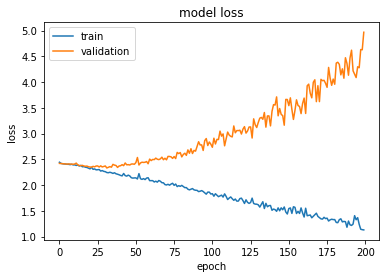

In [232]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

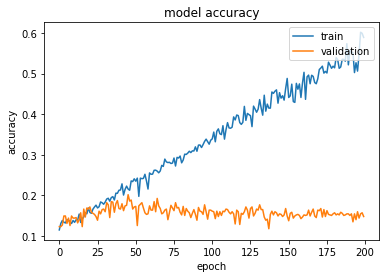

In [233]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [234]:
y_pred = model.predict_classes(x_test)
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [235]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_classes))

              precision    recall  f1-score   support

           0       0.12      0.25      0.16        32
           1       0.12      0.11      0.11        95
           2       0.27      0.40      0.32        40
           3       0.26      0.24      0.25       133
           4       0.05      0.06      0.05        35
           5       0.24      0.19      0.21       105
           6       0.29      0.22      0.25       170
           7       0.05      0.11      0.06        19
           8       0.20      0.14      0.16       131
           9       0.02      0.04      0.02        27
          10       0.15      0.15      0.15       103
          11       0.07      0.09      0.08        64

    accuracy                           0.18       954
   macro avg       0.15      0.17      0.15       954
weighted avg       0.19      0.18      0.18       954



<b> Observation:</b><li>We tried different ANN architectures but none of them are giving good accuracy.<li>Let us now try convolutional neural network

### Convolution neural network

In [17]:
x_feature = []
y_feature = []
img_rows = 256
img_cols = 256
idx = 0
abs_path = r"/content/drive/MyDrive/GLAssignments/Plant Seedling Classification Data/train/"
train_folder = os.listdir(abs_path)
for i in tqdm(train_folder):
  path = abs_path+i
  files = os.listdir(path)
  generator = (path+'/'+file for file in files)
  for image in generator:
    img = cv2.imread(image,1) # 0 is to read image in grayscale mode
    img_resize = cv2.resize(img,(img_rows,img_cols))
    x_feature.append(img_resize)
    y_feature.append(i)

100%|██████████| 12/12 [00:52<00:00,  4.38s/it]


In [8]:
pickle_list(r'/content/drive/MyDrive/GLAssignments/','xfeature.pkl',x_feature)

### Normalization

In [18]:
encoder = LabelEncoder()
X = np.array(x_feature,np.float32)/255
y_encoded = np.array(encoder.fit_transform(y_feature))
y = tensorflow.keras.utils.to_categorical(y_encoded,num_classes=None, dtype='int')

In [12]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)
print (x_train.shape)
print (x_val.shape)

(3813, 256, 256, 3)
(954, 256, 256, 3)


In [35]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (img_rows, img_cols, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))

model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 64)       

### Defining custom metrics

In [5]:
def recall_c(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_c(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_c(y_true, y_pred)
    recall = recall_c(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

### Defining callbacks

In [20]:
my_callbacks = [EarlyStopping(monitor='f1_score', patience=300, verbose=1, mode='max')]

In [ ]:
adam = tensorflow.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy',f1_score])
history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size = 20, 
                    validation_split=0.2,callbacks=my_callbacks)

In [26]:
y_pred = model.predict_classes(x_val)
y_classes = [np.argmax(y, axis=None, out=None) for y in y_val]
print(classification_report(y_pred,y_classes))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.33      0.86      0.47        21
           1       0.88      0.86      0.87        92
           2       0.67      0.91      0.77        43
           3       0.97      0.91      0.94       128
           4       0.79      0.95      0.86        40
           5       0.97      0.89      0.93       114
           6       0.92      0.73      0.81       150
           7       0.94      0.94      0.94        50
           8       0.98      0.81      0.89       108
           9       0.67      0.64      0.65        44
          10       0.97      0.96      0.96       100
          11       0.81      0.98      0.89        64

    accuracy                           0.86       954
   macro avg       0.82      0.87      0.83       954
weighted avg       0.89      0.86      0.87       954



In [28]:
model.save("/content/drive/MyDrive/GLAssignments/PlantADAM.h5")

### From above we can observe that overall weighted average f1score of our current model is 0.87 which is much better than supervised and ann scores.  

### Submission

In [8]:
dependencies = {
    'f1_score': f1_score
}

best_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/GLAssignments/PlantADAM.h5',custom_objects=dependencies)


In [9]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)       

In [10]:
test_features = []
img_rows = img_cols = 256
test_path = r"/content/drive/MyDrive/GLAssignments/Plant Seedling Classification Data/test/"
for image in tqdm(os.listdir(test_path)):
  img = cv2.imread(test_path+image,1)
  img_resize = cv2.resize(img,(img_rows,img_cols))
  test_features.append(img_resize) 

100%|██████████| 794/794 [00:04<00:00, 171.24it/s]


In [11]:
x_test = np.array(test_features,np.float32)/255
print(x_test.shape)

(794, 256, 256, 3)


In [ ]:
y_pred = best_model.predict_classes(x_test)

In [24]:
test_path = r"/content/drive/MyDrive/GLAssignments/Plant Seedling Classification Data/test/"

results = pd.DataFrame({'file':os.listdir(test_path),'species':encoder.inverse_transform(y_pred)})

In [26]:
results.to_csv("/content/drive/MyDrive/GLAssignments/submissions.csv",index=False)